In [1]:
import numpy as np
import pandas as pd,os
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from library.utils import read_data

In [3]:
filtered = pd.read_csv("Results/All_filter_PRC.csv",header=[0,1],index_col=0)  # All_filter_MCC.csv
filtered.shape

(32, 80)

## Dataset Characteristic vs MCC

In [4]:
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]

In [5]:
dependent = filtered.drop(columns='none',level=0)
dependent.shape

(32, 72)

In [6]:
df = pd.DataFrame(columns=['noise','FP','FN','TP','TN','nIR','IR','PR','Rec','MCC'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=False)
    noise = (y_noisy!=y_real).sum()/len(y_noisy)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    nIR = (y_noisy==0).sum()/y_noisy.sum()
    IR = (y_real==0).sum()/y_real.sum()
    pr = precision_score(y_real,y_noisy)
    rec = recall_score(y_real,y_noisy)
    for col in dependent.columns:
        df.loc[len(df)] = [noise,fp,fn,tp,tn,nIR,IR,pr,rec]+[dependent.loc[d,col]]
        
df['size'] = df['TN']+df['FN']+df['TP']+df['FP']
df.shape,df.isna().sum().sum()

((2304, 11), 0)

In [7]:
df.describe()

,noise,FP,FN,TP,TN,nIR,IR,PR,Rec,MCC,size
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,0.150005,106.281250,159.375000,65.000000,1962.937500,14.967926,12.309045,0.417170,0.369413,0.423801,2293.593750
std,0.072826,76.573883,135.134092,32.769514,1923.343527,12.388692,10.615920,0.183525,0.197020,0.138471,1948.112436
min,0.023513,12.000000,5.000000,14.000000,543.000000,3.097826,1.969743,0.154079,0.065728,0.000000,731.000000
25%,0.092036,52.000000,70.250000,42.750000,910.750000,5.714209,4.239589,0.261349,0.190374,0.331696,1285.500000
50%,0.133214,76.500000,127.000000,57.000000,1344.000000,12.648854,8.244744,0.445781,0.367217,0.437144,1717.500000
75%,0.204495,145.000000,187.750000,93.000000,2105.250000,18.499397,15.566327,0.523205,0.515233,0.520595,2419.750000
max,0.289862,280.000000,550.000000,136.000000,8546.000000,56.869565,45.072917,0.773585,0.807692,0.769036,8846.000000


In [8]:
dataStat = df.loc[::dependent.shape[1]].drop(columns=['MCC'])
dataStat.corr()

,noise,FP,FN,TP,TN,nIR,IR,PR,Rec,size
noise,1.000000,0.003989,0.530921,0.394874,-0.604112,-0.510341,-0.745125,0.334167,-0.151932,-0.552804
FP,0.003989,1.000000,-0.394866,0.090790,0.245745,-0.319471,0.383242,-0.688314,0.363664,0.256064
FN,0.530921,-0.394866,1.000000,0.405652,-0.003925,0.188557,-0.418024,0.644037,-0.697640,0.056795
TP,0.394874,0.090790,0.405652,1.000000,0.035472,-0.341250,-0.268020,0.534875,0.105204,0.083549
TN,-0.604112,0.245745,-0.003925,0.035472,1.000000,0.619920,0.808073,-0.189593,-0.166302,0.997270
nIR,-0.510341,-0.319471,0.188557,-0.341250,0.619920,1.000000,0.419101,0.013025,-0.574179,0.606820
IR,-0.745125,0.383242,-0.418024,-0.268020,0.808073,0.419101,1.000000,-0.541347,0.238465,0.779358
PR,0.334167,-0.688314,0.644037,0.534875,-0.189593,0.013025,-0.541347,1.000000,-0.302146,-0.160566
Rec,-0.151932,0.363664,-0.697640,0.105204,-0.166302,-0.574179,0.238465,-0.302146,1.000000,-0.196516
size,-0.552804,0.256064,0.056795,0.083549,0.997270,0.606820,0.779358,-0.160566,-0.196516,1.000000


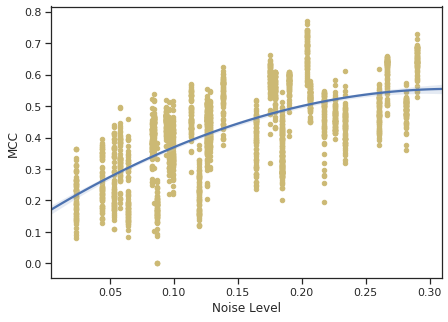

In [9]:
plt.figure(figsize=(7,5))
plt.scatter(df['noise'],df['MCC'],s=20,color='y')
f = sns.regplot(x='noise',y='MCC',data=df,robust=False,order=2,ci=95,scatter=False); #line_kws={'color':'green'}
plt.xlabel("Noise Level");

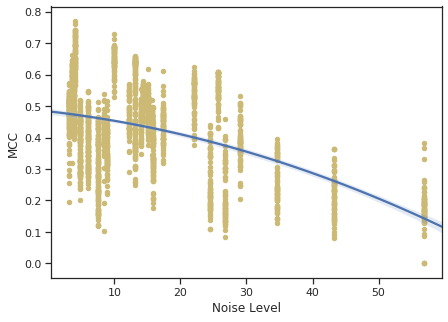

In [11]:
plt.figure(figsize=(7,5))
plt.scatter(df['nIR'],df['MCC'],s=20,color='y')
f = sns.regplot(x='nIR',y='MCC',data=df,robust=False,order=2,ci=95,scatter=False); #line_kws={'color':'green'}
plt.xlabel("Noise Level");

In [12]:
for col in df:
    if col=='MCC': continue
    print(col)
    print(pg.corr(df[col],df['MCC'],method='percbend'),'\n\n') #shepherd , percbend

noise
             n      r         CI95%     r2  adj_r2          p-val  power
percbend  2304  0.651  [0.63, 0.67]  0.424   0.423  7.152986e-278    1.0 


FP
             n      r           CI95%     r2  adj_r2         p-val  power
percbend  2304 -0.357  [-0.39, -0.32]  0.127   0.127  4.217251e-70    1.0 


FN
             n      r         CI95%     r2  adj_r2         p-val  power
percbend  2304  0.273  [0.23, 0.31]  0.074   0.074  1.360261e-40    1.0 


TP
             n      r         CI95%     r2  adj_r2         p-val  power
percbend  2304  0.381  [0.35, 0.42]  0.145   0.145  1.294627e-80    1.0 


TN
             n      r           CI95%     r2  adj_r2          p-val  power
percbend  2304 -0.618  [-0.64, -0.59]  0.382   0.381  7.114409e-243    1.0 


nIR
             n      r           CI95%     r2  adj_r2         p-val  power
percbend  2304 -0.356  [-0.39, -0.32]  0.127   0.126  1.081913e-69    1.0 


IR
             n     r           CI95%     r2  adj_r2  p-val  power
percbend  2